In [2]:
from pathlib import Path

thispath = Path('__file__').resolve()
base_path = thispath.parent.parent
import sys; sys.path.insert(0, str(base_path))
from dataset.copd_dataset import DirLabCOPD

import matplotlib.pyplot as plt
import preprocess.preprocess as preprocess
from utils import metrics
import time
import pandas as pd
import ants
import numpy as np
from tqdm import tqdm
import json

In [3]:
# Dataset
data_path = Path('/home/kaouther/Documents/GitHub/mira_final_project/data')

data = DirLabCOPD(
    data_path=data_path,
    cases=['all'],
    partitions=['train'],
    return_lm_mask=False,
    normalization_cfg=None,
    return_body_masks=False,
    return_lung_masks=False
)

In [4]:
len(data)

4

## Demonstration

In [5]:
sample = data[0]
fixed = ants.image_read(sample['e_img_path']) 
spacing = fixed.spacing
origin = fixed.origin
direction = fixed.direction

In [6]:
fixed = ants.from_numpy(sample['e_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
moving = ants.from_numpy(sample['i_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
# lm_mask = ants.from_numpy(sample['e_lm_mask'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)

In [7]:
fixed = ants.iMath(fixed, 'Normalize', 0.0, 1.0)
fixed = ants.iMath_truncate_intensity( fixed, 0.05, 0.95)
moving = ants.iMath(moving, 'Normalize', 0.0, 1.0)
moving = ants.iMath_truncate_intensity(moving, 0.05, 0.95 )

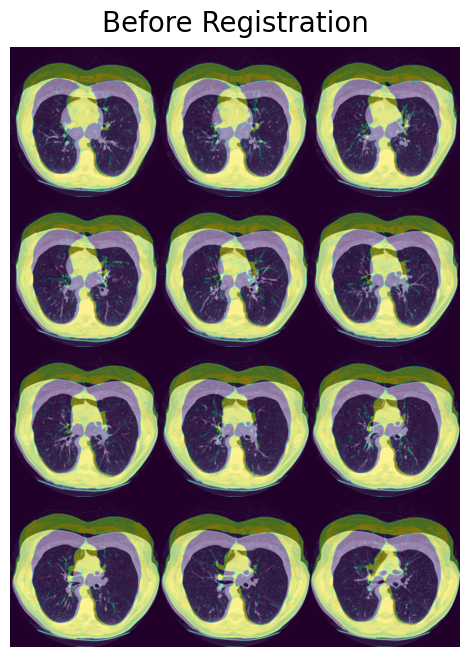

In [8]:
fixed.plot(overlay=moving, title='Before Registration', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=2)

In [9]:
mytx = ants.registration(fixed=fixed, 
                         moving=moving, 
                         #outprefix='/home/kaouther/Documents/GitHub/mira_final_project/ants/transforms/',
                         type_of_transform="SyNOnly",
                         syn_sampling=32,
                         reg_iterations=(100, 100, 50, 5, 0),
                         syn_metric='MI',
                         verbose=True)

antsRegistration -d 3 -r [0x559a4f01f050,0x559a4f050060,1] -m MI[0x559a4f01f050,0x559a4f050060,1,32] -t SyN[0.200000,3.000000,0.000000] -c [100x100x50x5x0,1e-7,8] -s 4x3x2x1x0 -f 16x8x4x2x1 -u 1 -z 1 -o [/tmp/tmpj2uwyepk,0x559a4f04f790,0x559a4f0555c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x559a4f01f050 and moving image: 0x559a4f050060 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
  number of levels = 5
  fixed image: 0x559a4f01f050
  moving image: 0x559a4f050060
Dimension = 3
Number of stages = 1
Use Histogram Matching true
Winsorize image intensities false
Lower quantile = 0
Upper quantile = 1
Stage 1 State
   Image metric = Mattes
     Fixed image = Image (0x559a4f1cf4a0)
  RTTI typeinfo:   itk::Image<float, 3u>
  Referen

In [10]:
registered = mytx['warpedmovout']

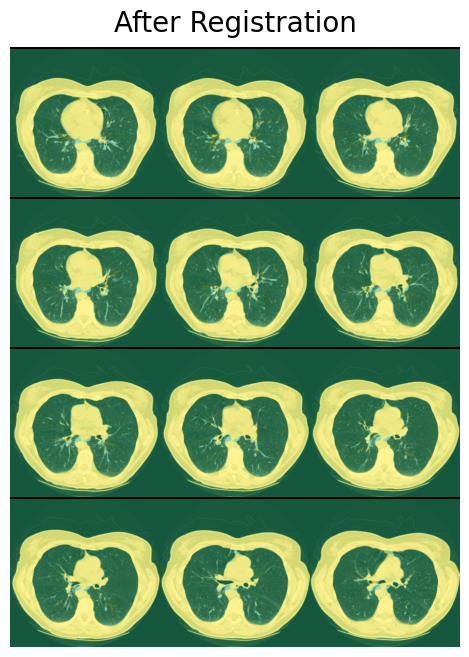

In [11]:
fixed.plot(overlay=registered, title='After Registration', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=2)

In [12]:
case_path = Path(sample['i_img_path']).parent
lm_filepath_fixed = case_path / f"{sample['case']}_eBHCT_lm.csv"
lm_filepath_moving = case_path / f"{sample['case']}_iBHCT_lm.csv"
landmarks_fixed_df = pd.read_csv(lm_filepath_fixed)
landmarks_moving_df = pd.read_csv(lm_filepath_moving)

landmarks_fixed_df = landmarks_fixed_df[['x', 'y','z']]
landmarks_moving_df = landmarks_moving_df[['x', 'y','z']]

landmarks_fixed = landmarks_fixed_df.to_numpy(dtype=np.float32)

landmarks_result = ants.apply_transforms_to_points(3, landmarks_moving_df, mytx['invtransforms'], whichtoinvert=[True, False]).to_numpy(dtype=np.float32)
tre = metrics.target_registration_error(landmarks_result, landmarks_fixed, [1.0, 1.0, 1.0])

print(f'TRE: {tre[0]}, {tre[1]}')
print(f'Initial displacement GT: {sample["disp_mean"]}, {sample["disp_std"]}')

TRE: 11.61, 6.75
Initial displacement GT: 25.9, 11.57


TRE: 24.35, 9.24
Initial displacement GT: 25.9, 11.57

## Experiments

In [13]:
def register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask = False, save_registered = False):

    res_dir = Path('/home/kaouther/Documents/GitHub/mira_final_project/ants/transforms')
    res_path = res_dir/ exp_name / sample['case']
    res_path.mkdir(exist_ok=True, parents=True)
    #res_path = f"/home/kaouther/Documents/GitHub/mira_final_project/ants//transforms/{sample['case']}/"
    
    
    fixed = ants.image_read(sample['e_img_path']) 
    spacing = fixed.spacing
    origin = fixed.origin
    direction = fixed.direction

    fixed = ants.from_numpy(sample['e_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
    moving = ants.from_numpy(sample['i_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)

    if use_mask:
        mask = ants.from_numpy(sample['e_lung_mask'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
    else:
        mask = None

    fixed = ants.iMath(fixed, 'Normalize', 0.0, 1.0)
    fixed = ants.iMath_truncate_intensity( fixed, 0.05, 0.95)
    moving = ants.iMath(moving, 'Normalize', 0.0, 1.0)
    moving = ants.iMath_truncate_intensity(moving, 0.05, 0.95)

    start = time.time()
    mytx = ants.registration(   fixed=fixed, 
                                moving=moving,
                                outprefix=str(res_path),
                                type_of_transform=transform,
                                syn_sampling= sampling,
                                syn_metric=metric,
                                reg_iterations=iterations,
                                mask=mask)
                                
                                
    reg_time = time.time() - start

    if save_registered:
        img_path = res_path / f"{sample['case']}_registered.nii.gz"
        ants.image_write(mytx['warpedmovout'], str(img_path))

    case_path = Path(sample['i_img_path']).parent
    lm_filepath_fixed = case_path / f"{sample['case']}_eBHCT_lm.csv"
    lm_filepath_moving = case_path / f"{sample['case']}_iBHCT_lm.csv"
    landmarks_fixed_df = pd.read_csv(lm_filepath_fixed)
    landmarks_moving_df = pd.read_csv(lm_filepath_moving)

    landmarks_fixed_df = landmarks_fixed_df[['x', 'y','z']]
    landmarks_moving_df = landmarks_moving_df[['x', 'y','z']]

    landmarks_fixed = landmarks_fixed_df.to_numpy(dtype=np.float32)

    landmarks_result = ants.apply_transforms_to_points(3, landmarks_moving_df, mytx['invtransforms'], whichtoinvert=[True, False]).to_numpy(dtype=np.float32)
    tre = metrics.target_registration_error(landmarks_result, landmarks_fixed, [1.0, 1.0, 1.0])

    return tre, reg_time

In [19]:
base_path = Path().resolve().parent

### Exp 01

In [20]:

results_path = base_path / 'experiments/ants/results.json'
exp_name = "synonly_mse_nomask"

transform = "SyNOnly" 
metric = "meansquares"
iterations = (160, 80, 20, 1)
sampling = 32 
use_mask = False 
save_registered = False

In [21]:
results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

100%|██████████| 4/4 [18:45<00:00, 281.36s/it]


In [22]:
results_exp

{'copd1': {'mean_tre': 15.25, 'std_tre': 7.93, 'time': 276.9923367500305},
 'copd2': {'mean_tre': 17.68, 'std_tre': 6.44, 'time': 198.89383792877197},
 'copd3': {'mean_tre': 8.1, 'std_tre': 3.76, 'time': 240.47665739059448},
 'copd4': {'mean_tre': 18.95, 'std_tre': 5.38, 'time': 390.7443335056305}}

In [23]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

 ### Exp 02

In [14]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "synonly_mi_nomask"

transform = "SyNOnly" 
metric = "MI"
iterations = (100, 100, 50, 5, 0)
sampling = 32 
use_mask = False 
save_registered = False

In [15]:
results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

100%|██████████| 4/4 [08:45<00:00, 131.31s/it]


In [16]:
results_exp

{'copd1': {'mean_tre': 11.61, 'std_tre': 6.75, 'time': 131.45556569099426},
 'copd2': {'mean_tre': 16.19, 'std_tre': 6.05, 'time': 105.85038948059082},
 'copd3': {'mean_tre': 6.5, 'std_tre': 3.87, 'time': 129.4522671699524},
 'copd4': {'mean_tre': 18.3, 'std_tre': 6.06, 'time': 139.96643829345703}}

### Exp 03

In [17]:
results_path = base_path / 'experiments/ants/results.json'
exp_name = "synonly_demons_nomask"

transform = "SyNOnly" 
metric = "demons"
iterations = (100, 100, 50, 5, 0)
sampling = 32 
use_mask = False 
save_registered = False

results_exp = {}
for i in tqdm(range(len(data))):
    sample = data[i]
    tre, reg_time = register_ants(exp_name, sample, transform, metric, iterations, sampling, use_mask, save_registered)
    results_exp[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }



100%|██████████| 4/4 [13:05<00:00, 196.46s/it]


In [18]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = results_exp
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

In [19]:
results_exp

{'copd1': {'mean_tre': 19.91, 'std_tre': 10.23, 'time': 241.62739825248718},
 'copd2': {'mean_tre': 22.84, 'std_tre': 11.04, 'time': 175.9004271030426},
 'copd3': {'mean_tre': 17.41, 'std_tre': 9.33, 'time': 185.6550052165985},
 'copd4': {'mean_tre': 19.77, 'std_tre': 7.76, 'time': 164.82798957824707}}